# CIFAR 10 Classification

In this project, you'll classify images from the CIFAR-10 dataset. The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded. You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers. At the end, you'll get to see your neural network's predictions on the sample images.

### Download the CIFAR-10 dataset

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
from tqdm import tqdm_notebook
from time import sleep
import tarfile
import numpy as np
import itertools
import seaborn as sn

cifar10_dataset_folder_path = 'cifar-10-batches-py'


tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

### Basic Functions Setup

In [2]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [3]:
import pickle

def load_cifar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

label_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def show_image(ax, image, label_id):
    ax.imshow(image)
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label ID: {} - {}'.format(label_id, label_names[label_id]), size = 12)

### Data Exploration

In [5]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

# Data Exploration
images, labels = load_cifar10_batch(cifar10_dataset_folder_path, 1)

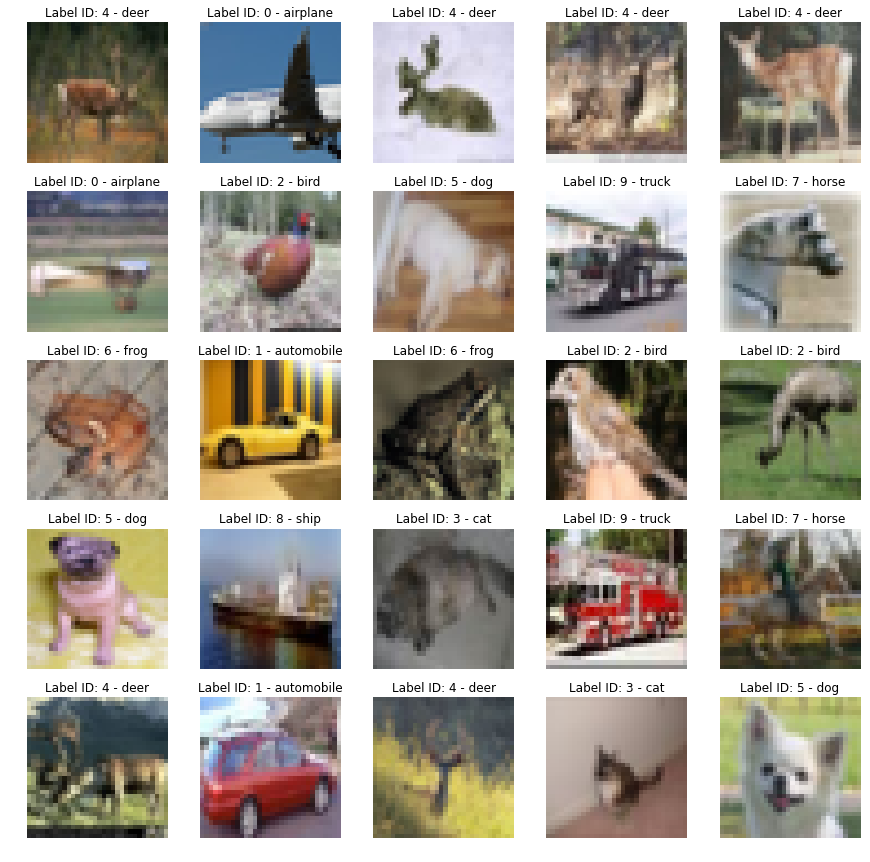

In [6]:
fig, ax = plt.subplots(figsize = (15,15), nrows = 5, ncols = 5)
img_num = random.sample(range(len(labels)), 25)
for i, axis in enumerate(ax.flatten()):
    show_image(axis, images[img_num[i],:,:,:], labels[img_num[i]])

### Analyse the training/sampe distribution in each file

In [7]:
all_labels = []
for i in range(1,6):
    _, labels = load_cifar10_batch(cifar10_dataset_folder_path, i)
    all_labels.append(labels)

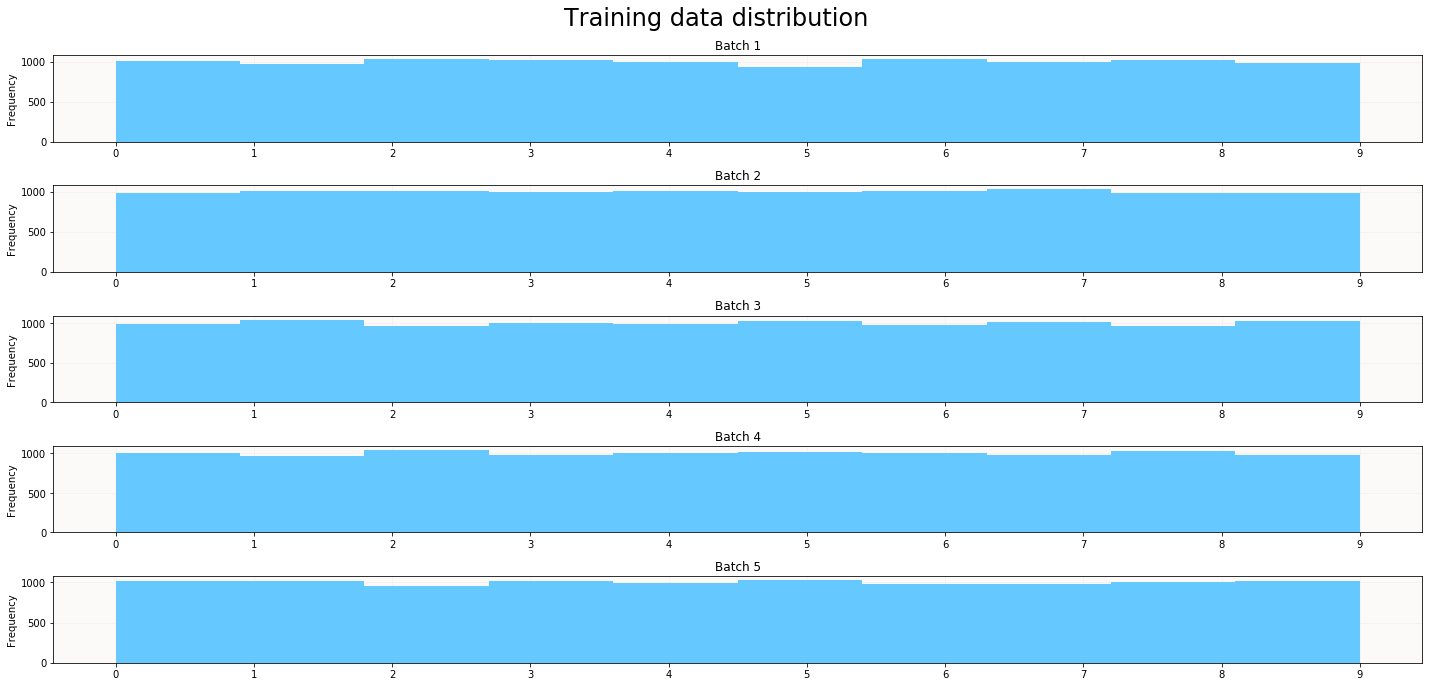

In [8]:
fig, ax = plt.subplots(figsize = (20,10), nrows = 5)
for i, ax_ in enumerate(ax):
    ax_.hist(all_labels[i], color = '#65c9ff')
    ax_.grid(alpha = 0.1)
    ax_.set_axisbelow(True)
    ax_.set_facecolor('#fcfaf8')
    start, end = ax_.get_xlim()
    ax_.xaxis.set_ticks(np.arange(0, 10, 1))
    ax_.set_title('Batch {}'.format(i+1))
    ax_.set_ylabel('Frequency')

fig.suptitle('Training data distribution', size=24)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

It seems that we have a good distribution for each of the samples in each batch data. We can use this later to run our Cross Validation during training.

### Preprocessing Functions Setup

In [9]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x/255

In [10]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    temp = np.zeros((len(x), 10))
    temp[np.arange(len(x)), x] = 1
    
    return temp

In [11]:
def preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cifar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)
    
        # Prprocess and save a batch of training data
        preprocess_and_save(
            normalize,
            one_hot_encode,
            features,
            labels,
            'preprocess_batch_' + str(batch_i) + '.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

In [12]:
def return_batches(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_file(filename, batch_size):
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return return_batches(features, labels, batch_size)

### Preprocess data and save it for future usage

In [13]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Network Building

### Input Placeholders

Here we create 3 functions to create placeholders for our neural network later on

In [13]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    x = tf.placeholder(tf.float32, shape = [None, image_shape[0], image_shape[1], image_shape[2]], name = 'x')
    return x 


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    y = tf.placeholder(tf.float32, [None, n_classes], name = 'y')
    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name = 'keep_prob')

### Convolution and Max Pooling Layers

Below we will create a higher level function to perform:
1. Convolution
2. Pooling

on our image features. During the network builing process, we'll utilize this function to execute our convolution and pooling for us.

In [14]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight_size = [conv_ksize[0], conv_ksize[1],
                   x_tensor.get_shape().as_list()[3],conv_num_outputs]
    conv_strides = [1, conv_strides[0], conv_strides[1], 1]
    
    weight = tf.Variable(tf.truncated_normal(weight_size, 
                                             stddev=1.0/(weight_size[2])**0.5), 
                         name = 'weight')
    
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    conv = tf.nn.conv2d(x_tensor, weight, conv_strides, 'SAME') + bias
    return conv


In [15]:
def maxpool(x_tensor, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """

    pool_size = [1,pool_ksize[0],pool_ksize[1],1]
    pool_strides = [1, pool_strides[0], pool_strides[1],1]

    conv = tf.nn.max_pool(x_tensor, pool_size, pool_strides, 'SAME')
    return conv


### Flatten

Below we create a function to flatten our final layer form our CNN in order to feed them properly to our NN

In [16]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    size = x_tensor.get_shape().as_list()
    size[0] = 1
    total_size = np.prod(size)
    return tf.reshape(x_tensor, [-1,total_size], name = "flatten")

### Fully Connected Layer

Build a fully connected neural network which receives input from our CNN. We will use relu as our activation function.

In [17]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    x_size = x_tensor.get_shape().as_list()
    weight_size = [x_size[1], num_outputs]
    weight_full = tf.Variable(tf.truncated_normal(weight_size, stddev=1.0/(weight_size[0])**0.5))
    bias_full = tf.Variable(tf.zeros([num_outputs]))
    return tf.nn.relu(tf.add(tf.matmul(x_tensor, weight_full), bias_full))

### Output Layer

We create output layer which calculates the final logit of our network. This output will be the one we use to determine the prediction based on the input data

In [18]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    x_size = x_tensor.get_shape().as_list()
    weight_size = [x_size[1], num_outputs]
    weight_full = tf.Variable(tf.truncated_normal(weight_size, stddev=1.0/(weight_size[0])**0.5))
    bias_full = tf.Variable(tf.zeros([num_outputs]))
    return tf.add(tf.matmul(x_tensor,weight_full), bias_full)

### Constructing the network

Now that we have all the functions to build our CNN, we will build one below, with structure as follows:

**Input > [Convolution > Max Pooling] x 2 > Full Connected > Dropout > Fully Connected > Output**

In [19]:
def conv_net(conv, param):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    keep_prob = param
    
    conv = conv2d(conv, conv_num_outputs = 24, conv_ksize = [3,3], conv_strides = [2,2])
    conv = maxpool(conv, pool_ksize = [2,2], pool_strides = [2,2])
    conv = conv2d(conv, conv_num_outputs = 48, conv_ksize = [3,3], conv_strides = [2,2])
    conv = maxpool(conv, pool_ksize = [2,2], pool_strides = [2,2])
    
    # Flattern results to a N x 1 dimensional array
    flat = flatten(conv)
    
    # Build a fully connected layer for prediction
    FNN = fully_conn(flat, 40)
    FNN = tf.nn.dropout(FNN, keep_prob)
    FNN = fully_conn(FNN, 20)

    out = output(FNN, 10)

    return out

Setup the network and hyperparameters

In [20]:
def build_basic_graph(model, param):
    # Inputs
    x = neural_net_image_input((32, 32, 3))
    y = neural_net_label_input(10)

    # Model
    logits = model(x, param)
    logits = tf.identity(logits, name='logits')
    
    # Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
    return x, y, logits, cost, correct_pred, accuracy

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Graph Specific 
fnn_keep_prob = neural_net_keep_prob_input()
x, y, logits, cost, correct_pred, accuracy = build_basic_graph(conv_net, (fnn_keep_prob))
optimizer = tf.train.AdamOptimizer().minimize(cost)

In [21]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    _, cost, acc = session.run(
        [optimizer, cost, accuracy],
        feed_dict={x: valid_features, y: valid_labels, fnn_keep_prob: 1})
    print('Cost = {:.4f}, Accuracy = {:.2f}%'.format(cost, acc*100))

In [22]:
valid_features, valid_labels = pickle.load(open('preprocess_batch_1.p', mode='rb'))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print_stats(sess, valid_features, valid_labels, cost, accuracy)

Cost = 3.7465, Accuracy = 10.27%


### Setting up Hyperparameters

In [39]:
epochs = 15
batch_size = 256
keep_probability = 0.5
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [27]:
hist = []

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in tqdm_notebook(range(epochs), desc='Epoch'):
        for batch_i in range(4):
            filename = 'preprocess_batch_' + str(batch_i+1) + '.p'
            for batch_features, batch_labels in load_preprocess_file(filename, batch_size):
                _, train_cost, train_acc = sess.run([optimizer, cost, accuracy],
                                        feed_dict={x: batch_features, 
                                                   y: batch_labels, 
                                                   fnn_keep_prob: 0.5})
        
        # Record performance every 5 epochs
        if (epoch+1)%2 == 0:
            valid_batch_acc_total = 0
            valid_batch_count = 0
            for valid_feature_batch, valid_label_batch in load_preprocess_file('preprocess_batch_5.p', batch_size):
                valid_cost, acc = sess.run([cost, accuracy], 
                               feed_dict= {x: valid_feature_batch, y: valid_label_batch, fnn_keep_prob: 1.0})

                valid_batch_acc_total += acc
                valid_batch_count += 1
            hist.append([train_cost, train_acc, valid_cost, valid_batch_acc_total/valid_batch_count])
        
hist = np.array(hist)
history_file = open('perf/conv_net1_performance_history.csv', 'w')
for epoch in hist:
    history_file.write(','.join(str(dat) for dat in epoch) + '\n')
history_file.close()

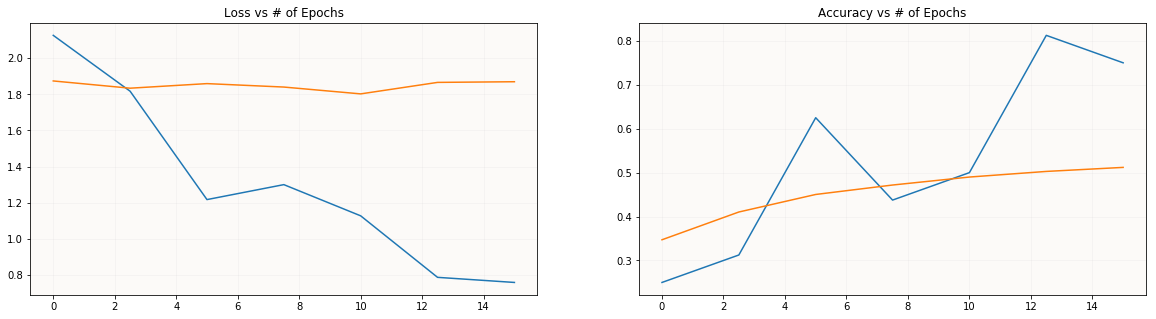

In [28]:
fig, ax = plt.subplots(figsize = (20,5), nrows = 1, ncols = 2)
ax[0].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,0], label = 'training loss')
ax[0].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,2], label = 'validation loss')
ax[0].set_title('Loss vs # of Epochs')
ax[1].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,1], label = 'training accuracy')
ax[1].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,3], label = 'validation accuracy')
ax[1].set_title('Accuracy vs # of Epochs')
for ax_ in ax:
    ax_.grid(alpha = 0.1)
    ax_.set_axisbelow(True)
    ax_.set_facecolor('#fcfaf8')
plt.show()

As we can see, the graph is training ok and we can see both validation and training accuracy increased. However, the training accuracy is still below 50%. Given it's only a small NN (2 mins training with CPU), it's understandable.

### Cross Validation for Hyper Parameters Selection

In [23]:
def cross_validation(sess, epochs, conv_keep_probability, 
                     fnn_keep_probability, batchNorm = False, full_CV = True):
    
    # Generate all cross validation permutations, N = 5
    l = list(range(1,6))
    cv = [(l[:k] + l[(k + 1):],[k+1]) for k in range(len(l))]
    
    # Given time constraint, only use the final permutation (hold-out validation)
    if not full_CV: cv = [cv[-1]]
    
    final_hist = []
    
    for train, validate in tqdm_notebook(cv, desc='CV'):
        sess.run(tf.global_variables_initializer())
        
        hist = []
        
        for epoch in tqdm_notebook(range(epochs), desc='Epochs', leave=False):
            for batch_i in train:
                    filename = 'preprocess_batch_' + str(batch_i) + '.p'
                    for batch_features, batch_labels in load_preprocess_file(filename, batch_size):
                        feed_dict = {x: batch_features, 
                                     y: batch_labels, 
                                     conv_keep_prob: conv_keep_probability,
                                     fnn_keep_prob: fnn_keep_probability}
                        if batchNorm:
                            feed_dict[is_training] = 1
                        _, train_cost, train_acc = sess.run([optimizer, cost, accuracy],
                                                            feed_dict=feed_dict)
        
            if (epoch+1)%2 == 0:
                # Get accuracy in batches for memory limitations
                valid_batch_acc_total = 0
                valid_batch_count = 0

                filename = 'preprocess_batch_' + str(validate[0]) + '.p'
                for valid_feature_batch, valid_label_batch in load_preprocess_file(filename, batch_size):
                    feed_dict = {x: valid_feature_batch, 
                                 y: valid_label_batch, 
                                 conv_keep_prob: 1.0,
                                 fnn_keep_prob: 1.0}
                    
                    if batchNorm:
                            feed_dict[is_training] = 0
                            
                    valid_cost, acc = sess.run([cost, accuracy], feed_dict= feed_dict)

                    valid_batch_acc_total += acc
                    valid_batch_count += 1 

                hist.append([train_cost, train_acc, valid_cost, 
                                        valid_batch_acc_total/valid_batch_count])
        final_hist.append(hist)
    
    return np.array(final_hist)

In [24]:
def conv_net2(conv, param):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : conv_keep_prob: Placeholder tensor that hold dropout keep probability.
    : fnn_keep_prob
    : normalize: Use batch normalization
    : conv_layer_param: list of conv net configuration (filter, conv_ksize, pool_ksize).
                        size of list represents # of conv layer
    : full_layer_param: list of fully connected layer size (excluding last layer).
                        size of list represents # of fully connected layer
    : return: Tensor that represents logits
    """
    
    conv_keep_prob, fnn_keep_prob, training, batchNorm = param
    
    conv = conv2d(conv, 32, [3, 3], [1, 1])
    conv = tf.nn.relu(conv)
    
    if batchNorm: conv = tf.layers.batch_normalization(conv, training=training)
    
    conv = conv2d(conv, 32, [3, 3], [1, 1])
    conv = tf.nn.relu(conv)
    conv = maxpool(conv, [2, 2], [2, 2])
    
    if batchNorm: conv = tf.layers.batch_normalization(conv, training=training)
    
    conv = tf.nn.dropout(conv, conv_keep_prob)
    
    conv = conv2d(conv, 64, [3, 3], [1, 1])
    conv = tf.nn.relu(conv)
    
    if batchNorm: conv = tf.layers.batch_normalization(conv, training=training)
    
    conv = conv2d(conv, 64, [3, 3], [1, 1])
    conv = tf.nn.relu(conv)
    conv = maxpool(conv, [2, 2], [2, 2])
    
    if batchNorm: conv = tf.layers.batch_normalization(conv, training=training)

    conv = tf.nn.dropout(conv, conv_keep_prob)
    
    conv = conv2d(conv, 128, [3, 3], [1, 1])
    conv = tf.nn.relu(conv)
    
    if batchNorm: conv = tf.layers.batch_normalization(conv, training=training)
    
    conv = conv2d(conv, 128, [3, 3], [1, 1])
    conv = tf.nn.relu(conv)
    conv = maxpool(conv, [2, 2], [2, 2])
    
    if batchNorm: conv = tf.layers.batch_normalization(conv, training=training)        
        
    FNN = tf.nn.dropout(conv, fnn_keep_prob)
    
    # Flattern results to a N x 1 dimensional array
    FNN = flatten(FNN)
    FNN = fully_conn(FNN, 128)
    
    if batchNorm: FNN = tf.layers.batch_normalization(FNN, training=training)
    
    out = output(FNN, 10)

    return out

In [26]:
epochs_all = [60]
batch_size = 256
conv_keep_probability_all = [0.9, 1]
fnn_keep_probability_all = [0.5, 1]
keep_probability_all = zip(conv_keep_probability_all, fnn_keep_probability_all)
learning_rate_all = [0.001]
batchNorm_all = [True, False]

In [27]:
import itertools

perm = itertools.product(epochs_all, keep_probability_all, learning_rate_all, batchNorm_all)
performance_history = []
CV_History = []

history_file = open('perf/performance_history.csv', 'w')
i = 0
for epochs, keep_probability, learning_rate, batchNorm in tqdm_notebook(perm, desc='Perm'):
    
    conv_keep_probability, fnn_keep_probability = keep_probability
    
    # Build Graph
    tf.reset_default_graph()
    fnn_keep_prob = neural_net_keep_prob_input()
    conv_keep_prob = neural_net_keep_prob_input()
    is_training = tf.placeholder(tf.bool, name = 'training')
    
    network_param = (conv_keep_prob, fnn_keep_prob, is_training, batchNorm)
    x, y, logits, cost, correct_pred, accuracy = build_basic_graph(conv_net2, network_param)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.Session() as sess:
        # Training cycle
        validation_acc = cross_validation(sess, epochs, conv_keep_probability, 
                                          fnn_keep_probability, batchNorm, False)
        
        performance_history.append((epochs, batch_size, keep_probability, 
                                    learning_rate, batchNorm,
                                    validation_acc[:,-1,3].mean()*100))
        
        history_file.write(';'.join(str(dat) for dat in performance_history[-1])+ '\n')
        history_file.flush()
        
        CV_History.append(validation_acc)
        save_model_path = './model/image_classification{}'.format(i)
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)
        i += 1

history_file.close()
CV_History = np.array(CV_History)

In [28]:
output = open('perf/CV_History.pkl', 'wb')
pickle.dump(CV_History, output)
output.close()

In [29]:
import pandas as pd
head=['#Epoch', 'Batch Size', 'Keep p', 'lr', 'BN', 'Valid. Acc']
performance_record = pd.read_csv('perf/performance_history.csv', delimiter=';', names=head)
performance_record.sort_values('Valid. Acc', ascending=False).head(10)

,#Epoch,Batch Size,Keep p,lr,BN,Valid. Acc
0,60,256,"(0.9, 0.5)",0.001,True,80.234375
1,60,256,"(0.9, 0.5)",0.001,False,78.662109
2,60,256,"(1, 1)",0.001,True,70.341797
3,60,256,"(1, 1)",0.001,False,66.386719


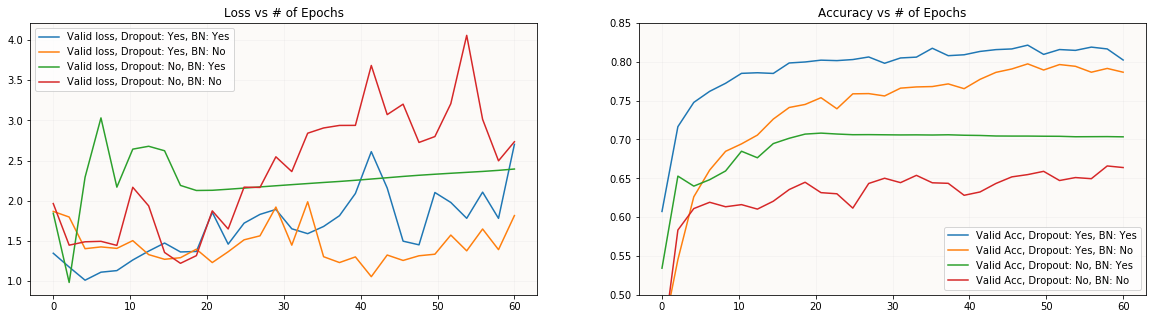

In [30]:
epochs=60
pkl_file = open('perf/CV_History.pkl', 'rb')
CV_History = pickle.load(pkl_file)
fig, ax = plt.subplots(figsize = (20,5), nrows = 1, ncols = 2)
for i, param in enumerate(itertools.product(['Yes', 'No'], ['Yes', 'No'])):
    label = 'Valid loss, Dropout: {}, BN: {}'.format(*param)
    ax[0].plot(np.linspace(0, epochs, int(epochs/2)), CV_History[i,0,:,2], label = label)
ax[0].set_title('Loss vs # of Epochs')
for i, param in enumerate(itertools.product(['Yes', 'No'], ['Yes', 'No'])):
    label = 'Valid Acc, Dropout: {}, BN: {}'.format(*param)
    ax[1].plot(np.linspace(0, epochs, int(epochs/2)), CV_History[i,0,:,3], label = label)
ax[1].set_title('Accuracy vs # of Epochs')
for ax_ in ax:
    ax_.grid(alpha = 0.1)
    ax_.set_axisbelow(True)
    ax_.set_facecolor('#fcfaf8')
    ax_.legend()
ax[1].set_ylim([0.5, 0.85])
plt.show()
pkl_file.close()

A few observations here:
- As expected, model 0 (with dropout and batch normalization) performs the best in our validation dataset. Current it's validation accuracy is about 82.5%. Given the trajectory, we should be able to train it for more epochs.
- Model 1 (dropout without batch normalization) and model 2 (batch normalization without dropout) performs very similarly after 60 epochs, however, model 2 is able to achieve the same result in just < 20 epochs.
- Model 3 (without dropout and without batch normalization) perfoms much worse compared to the other 3 model, with ~ 14% differences

In [42]:
epochs = 100
batch_size = 256
conv_keep_probability = 0.8
fnn_keep_probability = 0.4
learning_rate = 0.001
batchNorm = True

# Build Graph
tf.reset_default_graph()
fnn_keep_prob = neural_net_keep_prob_input()
conv_keep_prob = neural_net_keep_prob_input()
is_training = tf.placeholder(tf.bool, name = 'training')
network_param = (conv_keep_prob, fnn_keep_prob, is_training, batchNorm)
x, y, logits, cost, correct_pred, accuracy = build_basic_graph(conv_net2, network_param)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

with tf.Session() as sess:
    # Training cycle
    sess.run(tf.global_variables_initializer())
        
    hist = []
    train = [1,2,3,4]
    for epoch in tqdm_notebook(range(epochs), desc='Epochs', leave=False):
        for batch_i in train:
                filename = 'preprocess_batch_' + str(batch_i) + '.p'
                for batch_features, batch_labels in load_preprocess_file(filename, batch_size):
                    feed_dict = {x: batch_features, 
                                 y: batch_labels, 
                                 conv_keep_prob: conv_keep_probability,
                                 fnn_keep_prob: fnn_keep_probability}
                    if batchNorm:
                        feed_dict[is_training] = 1
                    _, train_cost, train_acc = sess.run([optimizer, cost, accuracy],
                                                        feed_dict=feed_dict)

        if (epoch+1)%2 == 0:
            # Get accuracy in batches for memory limitations
            valid_batch_acc_total = 0
            valid_batch_count = 0

            filename = 'preprocess_batch_5.p'
            for valid_feature_batch, valid_label_batch in load_preprocess_file(filename, batch_size):
                feed_dict = {x: valid_feature_batch, 
                             y: valid_label_batch, 
                             conv_keep_prob: 1.0,
                             fnn_keep_prob: 1.0}

                if batchNorm:
                        feed_dict[is_training] = 0

                valid_cost, acc = sess.run([cost, accuracy], feed_dict= feed_dict)

                valid_batch_acc_total += acc
                valid_batch_count += 1 

            hist.append([train_cost, train_acc, valid_cost, 
                                    valid_batch_acc_total/valid_batch_count])
        
        if (epoch+1)%5 == 0:
            save_model_path = './model/image_classification{}'.format(4)
            saver = tf.train.Saver()
            save_path = saver.save(sess, save_model_path)
            
hist = np.array(hist)

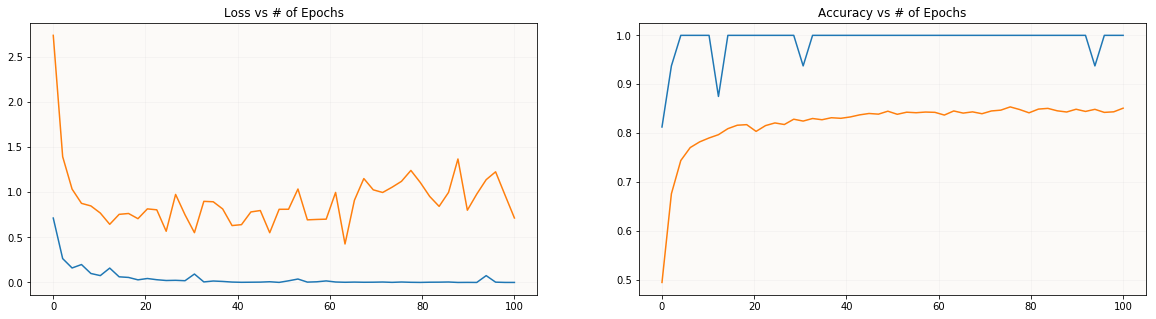

In [44]:
fig, ax = plt.subplots(figsize = (20,5), nrows = 1, ncols = 2)
ax[0].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,0], label = 'training loss')
ax[0].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,2], label = 'validation loss')
ax[0].set_title('Loss vs # of Epochs')
ax[1].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,1], label = 'training accuracy')
ax[1].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,3], label = 'validation accuracy')
ax[1].set_title('Accuracy vs # of Epochs')
for ax_ in ax:
    ax_.grid(alpha = 0.1)
    ax_.set_axisbelow(True)
    ax_.set_facecolor('#fcfaf8')
plt.show()

### Data Augmentation

In [61]:
def load_and_run(save_model_path, test_file):

    test_features, test_labels = pickle.load(open(test_file, mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_fnn_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_conv_keep_prob = loaded_graph.get_tensor_by_name('keep_prob_1:0')
        loaded_is_training = loaded_graph.get_tensor_by_name('training:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        prediction = []
        true_label = []

        for test_feature_batch, test_label_batch in return_batches(test_features, test_labels, 256):
            feed_dict = {loaded_x: test_feature_batch, 
                         loaded_y: test_label_batch, 
                         loaded_fnn_keep_prob: 1.0,
                         loaded_conv_keep_prob: 1.0,
                         loaded_is_training: 0}
            test_logits, test_batch_acc = sess.run([loaded_logits, loaded_acc], feed_dict=feed_dict)
            test_batch_acc_total += test_batch_acc
            test_batch_count += 1
            prediction.append(np.array(test_logits))
            true_label.append(np.array(test_label_batch))

    combined_pred = np.concatenate(prediction, axis = 0)
    combined_y = np.concatenate(true_label, axis = 0)
    
    return combined_pred, combined_y

combined_pred, combined_y = load_and_run('./model/image_classification4', 'preprocess_batch_5.p')

INFO:tensorflow:Restoring parameters from ./model/image_classification4


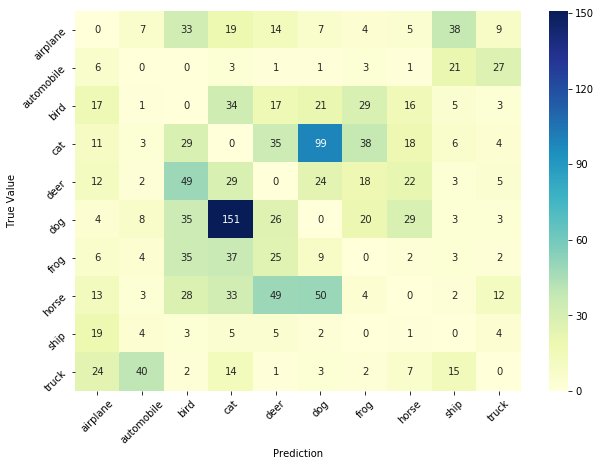

In [62]:
from sklearn.metrics import confusion_matrix
import pandas as pd
cf_matrix = confusion_matrix(np.argmax(combined_pred, axis = 1), np.argmax(combined_y, axis = 1))
#We set these values to 0 as we'd like to focus on the mistakes
np.fill_diagonal(cf_matrix, 0) 

df_cm = pd.DataFrame(cf_matrix)
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
_ = ax.set_ylabel('True Value')
_ = ax.set_xlabel('Prediction')
_ = ax.xaxis.set_ticklabels(label_names, rotation=45)
_ = ax.yaxis.set_ticklabels(label_names, rotation=45)

Based on the confusion matrix, it seems that our predictor is still confused in determining cat and dogs

#### Understanding our prediction
Below we will show a few incorrect plots that we're very unsure of (lowest probability) and very sure of (highest probability)

In [33]:
def show_image_prob(i, image, label_id, prob, shift):
    ax[i,0 + shift].imshow(image)
    ax[i,0 + shift].grid(False)
    ax[i,0 + shift].axis('off')
    ax[i,0 + shift].set_title('Label ID: {} - {}'.format(label_id, label_names[label_id]), size = 12)
    y_pos = np.arange(len(prob))
    ax[i,1 + shift].barh(y_pos,prob, align='center')
    ax[i,1 + shift].set_yticks(np.arange(len(label_names)))
    ax[i,1 + shift].set_yticklabels(label_names)
    ax[i,1 + shift].invert_yaxis()
    ax[i,1 + shift].set_title('Prediction probability')

In [34]:
images, labels = load_cifar10_batch(cifar10_dataset_folder_path, 5)

In [35]:
show = 8
correct_pred = np.argmax(combined_pred, axis = 1) == np.argmax(combined_y, axis = 1)
incorrect_pred = [(num, y, np.max(softmax(pred)), softmax(pred)) for num, (pred, y, corr)
                  in enumerate(zip(combined_pred, 
                                   np.argmax(combined_y, axis = 1), 
                                   correct_pred)) if not corr]
incorrect_pred.sort(key = lambda x: x[2])
lowest = incorrect_pred[:show]
highest = incorrect_pred[-show:]

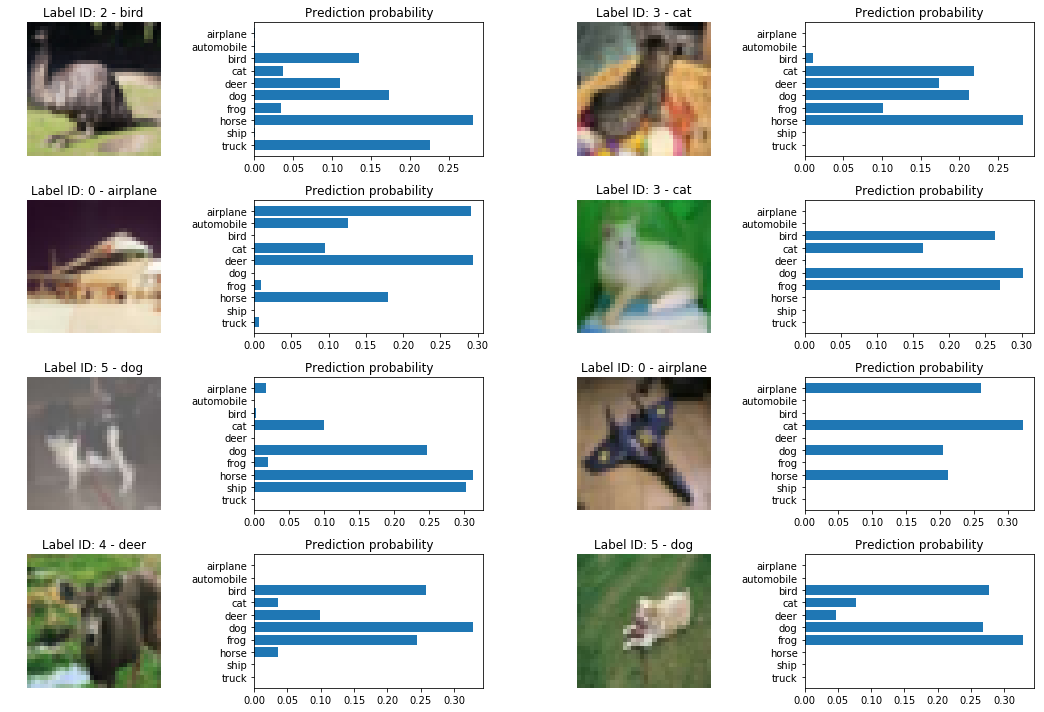

In [36]:
fig, ax = plt.subplots(figsize = (15,2.5*show/2), nrows = int(show/2), ncols = 4)
for i in range(len(ax)):
    show_image_prob(i, images[lowest[i*2][0]], labels[lowest[i*2][0]], lowest[i*2][3], 0)
    show_image_prob(i, images[lowest[i*2+1][0]], labels[lowest[i*2+1][0]], lowest[i*2+1][3], 2)
plt.tight_layout()

Some of the images above are indeed quite confusing. For example, picture number 7 is actually very similar to a dog, which we predicted.

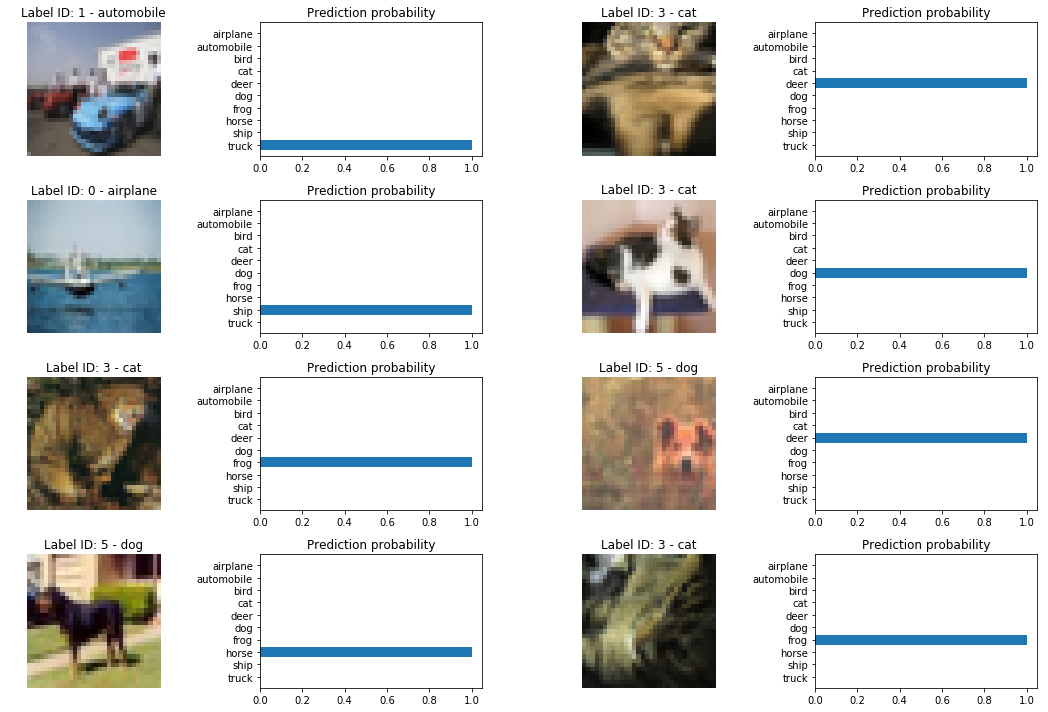

In [37]:
fig, ax = plt.subplots(figsize = (15,2.5*show/2), nrows = int(show/2), ncols = 4)
for i in range(len(ax)):
    show_image_prob(i, images[highest[i*2][0]], labels[highest[i*2][0]], highest[i*2][3], 0)
    show_image_prob(i, images[highest[i*2+1][0]], labels[highest[i*2+1][0]], highest[i*2+1][3], 2)
plt.tight_layout()

For most of these incorrect predictions, we are quite sure for our prediction, but again, for some of them it's understandable. We guess picture 1 as a truck given that there is a white box behind the automobile, making it look similar to a truck, while number 3 are dominated by blue color - which is very similar to a sea.

#### Simple Augmentation
Given our training data and validation history, it seems that our model is still overfitting (very high training accuracy, with ~15% gap to validation accuracy). To help improve training and prediction, we will use a a simple augmentation algorithm: Addition of Gaussian Noise, and image flipping.

In [42]:
epochs = 100
batch_size = 256
conv_keep_probability = 0.8
fnn_keep_probability = 0.4
learning_rate = 0.001
batchNorm = True

In [55]:
# Build Graph
tf.reset_default_graph()
fnn_keep_prob = neural_net_keep_prob_input()
conv_keep_prob = neural_net_keep_prob_input()
is_training = tf.placeholder(tf.bool, name = 'training')

network_param = (conv_keep_prob, fnn_keep_prob, is_training, batchNorm)
x, y, logits, cost, correct_pred, accuracy = build_basic_graph(conv_net2, network_param)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

with tf.Session() as sess:
    # Training cycle
    sess.run(tf.global_variables_initializer())
        
    hist = []
    train = [1,2,3,4]
    for epoch in tqdm_notebook(range(epochs), desc='Epochs', leave=False):
        for batch_i in train:
                filename = 'preprocess_batch_' + str(batch_i) + '.p'
                for batch_features, batch_labels in load_preprocess_file(filename, batch_size):
                    gaussian = batch_features + np.random.normal(0, 1/255, batch_features.shape)
                    flipped = np.flip(gaussian, axis = 2)
                    feed_dict = {x: np.concatenate((batch_features, gaussian, flipped), axis = 0), 
                                 y: np.concatenate((batch_labels, batch_labels, batch_labels), axis = 0), 
                                 conv_keep_prob: conv_keep_probability,
                                 fnn_keep_prob: fnn_keep_probability}
                    if batchNorm:
                        feed_dict[is_training] = 1
                    _, train_cost, train_acc = sess.run([optimizer, cost, accuracy],
                                                        feed_dict=feed_dict)

        if (epoch+1)%2 == 0:
            # Get accuracy in batches for memory limitations
            valid_batch_acc_total = 0
            valid_batch_count = 0

            filename = 'preprocess_batch_5.p'
            for valid_feature_batch, valid_label_batch in load_preprocess_file(filename, batch_size):
                feed_dict = {x: valid_feature_batch, 
                             y: valid_label_batch, 
                             conv_keep_prob: 1.0,
                             fnn_keep_prob: 1.0}

                if batchNorm:
                        feed_dict[is_training] = 0

                valid_cost, acc = sess.run([cost, accuracy], feed_dict= feed_dict)

                valid_batch_acc_total += acc
                valid_batch_count += 1 

            hist.append([train_cost, train_acc, valid_cost, 
                                    valid_batch_acc_total/valid_batch_count])
        
        if (epoch+1)%5 == 0:
            save_model_path = './model/image_classification_augmented{}'.format(0)
            saver = tf.train.Saver()
            save_path = saver.save(sess, save_model_path)
            
hist = np.array(hist)
print(valid_batch_acc_total/valid_batch_count * 100)

87.421875


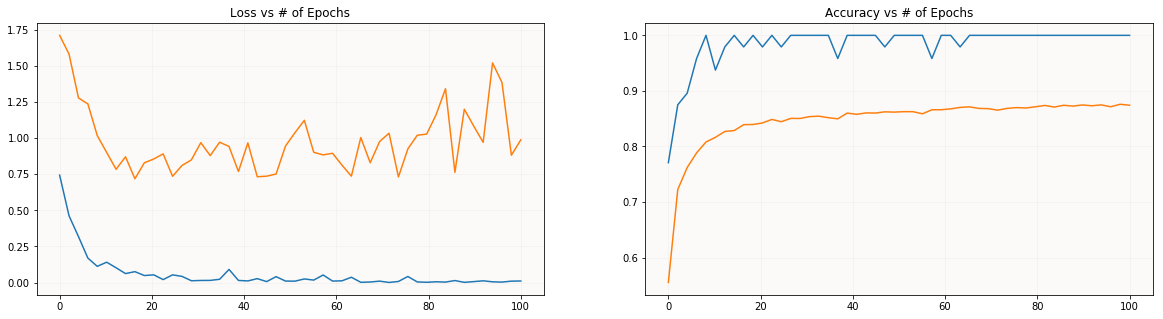

In [56]:
fig, ax = plt.subplots(figsize = (20,5), nrows = 1, ncols = 2)
ax[0].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,0], label = 'training loss')
ax[0].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,2], label = 'validation loss')
ax[0].set_title('Loss vs # of Epochs')
ax[1].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,1], label = 'training accuracy')
ax[1].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,3], label = 'validation accuracy')
ax[1].set_title('Accuracy vs # of Epochs')
for ax_ in ax:
    ax_.grid(alpha = 0.1)
    ax_.set_axisbelow(True)
    ax_.set_facecolor('#fcfaf8')
plt.show()

INFO:tensorflow:Restoring parameters from ./model/image_classification_augmented0


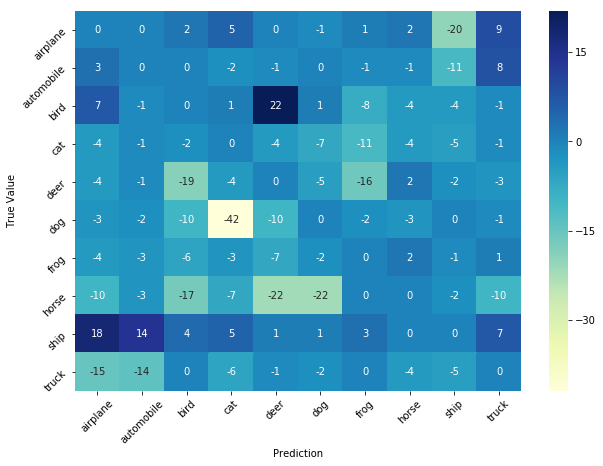

In [64]:
combined_pred, combined_y = load_and_run('./model/image_classification_augmented0', 'preprocess_batch_5.p')
cf_matrix2 = confusion_matrix(np.argmax(combined_pred, axis = 1), np.argmax(combined_y, axis = 1))
#We set these values to 0 as we'd like to focus on the mistakes
np.fill_diagonal(cf_matrix2, 0) 

# Plot the confusion matrix difference compared to non-augmented training
df_cm = pd.DataFrame(cf_matrix2 - cf_matrix)
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
_ = ax.set_ylabel('True Value')
_ = ax.set_xlabel('Prediction')
_ = ax.xaxis.set_ticklabels(label_names, rotation=45)
_ = ax.yaxis.set_ticklabels(label_names, rotation=45)

Based on the above, seems that we have good improvementa cross the board except on the ship related prediction. It seems that our data augmentation increase the probability to mistaken all the 10 classes as ship.

## Train Final Model

In [25]:
epochs = 100
batch_size = 256
conv_keep_probability = 0.8
fnn_keep_probability = 0.4
learning_rate = 0.001
batchNorm = True

In [26]:
# Build Graph
tf.reset_default_graph()
fnn_keep_prob = neural_net_keep_prob_input()
conv_keep_prob = neural_net_keep_prob_input()
is_training = tf.placeholder(tf.bool, name = 'training')

network_param = (conv_keep_prob, fnn_keep_prob, is_training, batchNorm)
x, y, logits, cost, correct_pred, accuracy = build_basic_graph(conv_net2, network_param)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

with tf.Session() as sess:
    # Training cycle
    sess.run(tf.global_variables_initializer())
        
    hist = []
    train = [1,2,3,4,5]
    for epoch in tqdm_notebook(range(epochs), desc='Epochs', leave=False):
        for batch_i in train:
                filename = 'preprocess_batch_' + str(batch_i) + '.p'
                for batch_features, batch_labels in load_preprocess_file(filename, batch_size):
                    gaussian = batch_features + np.random.normal(0, 1/255, batch_features.shape)
                    flipped = np.flip(gaussian, axis = 2)
                    feed_dict = {x: np.concatenate((batch_features, gaussian, flipped), axis = 0), 
                                 y: np.concatenate((batch_labels, batch_labels, batch_labels), axis = 0), 
                                 conv_keep_prob: conv_keep_probability,
                                 fnn_keep_prob: fnn_keep_probability}
                    if batchNorm:
                        feed_dict[is_training] = 1
                    _, train_cost, train_acc = sess.run([optimizer, cost, accuracy],
                                                        feed_dict=feed_dict)

        if (epoch+1)%2 == 0:
            # Get accuracy in batches for memory limitations
            valid_batch_acc_total = 0
            valid_batch_count = 0

            filename = 'preprocess_test.p'
            for valid_feature_batch, valid_label_batch in load_preprocess_file(filename, batch_size):
                feed_dict = {x: valid_feature_batch, 
                             y: valid_label_batch, 
                             conv_keep_prob: 1.0,
                             fnn_keep_prob: 1.0}

                if batchNorm:
                        feed_dict[is_training] = 0

                valid_cost, acc = sess.run([cost, accuracy], feed_dict= feed_dict)

                valid_batch_acc_total += acc
                valid_batch_count += 1 

            hist.append([train_cost, train_acc, valid_cost, 
                                    valid_batch_acc_total/valid_batch_count])
        
        if (epoch+1)%5 == 0:
            save_model_path = './model/image_classification_final'
            saver = tf.train.Saver()
            save_path = saver.save(sess, save_model_path)
            
hist = np.array(hist)

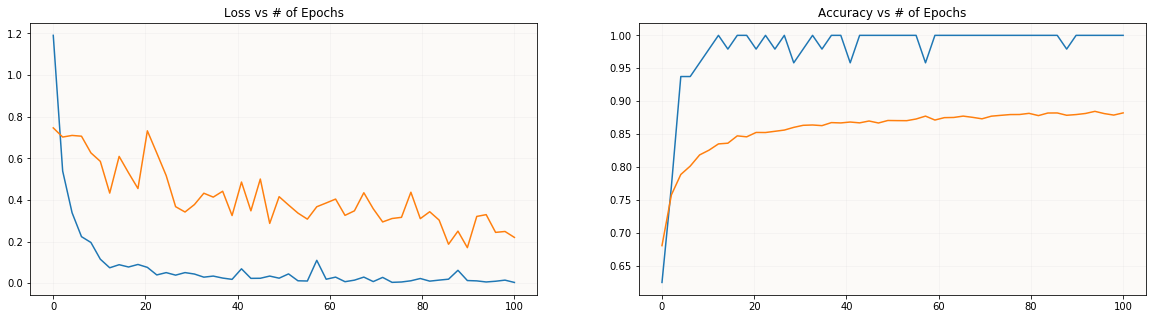

In [27]:
fig, ax = plt.subplots(figsize = (20,5), nrows = 1, ncols = 2)
ax[0].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,0], label = 'training loss')
ax[0].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,2], label = 'validation loss')
ax[0].set_title('Loss vs # of Epochs')
ax[1].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,1], label = 'training accuracy')
ax[1].plot(np.linspace(0, epochs, int(epochs/2)), hist[:,3], label = 'validation accuracy')
ax[1].set_title('Accuracy vs # of Epochs')
for ax_ in ax:
    ax_.grid(alpha = 0.1)
    ax_.set_axisbelow(True)
    ax_.set_facecolor('#fcfaf8')
plt.show()

Our final test result is 88.2%. Given the trajectory, we should be able to reach the 90% mark by running more epochs.